# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import numpy as np
import pandas as pd

import time

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify_Churn_Analysis") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.createOrReplaceTempView("log_table")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Let's first drop duplicates.

In [4]:
df = df.dropDuplicates()

and log entries from unregistered users

In [5]:
df = spark.sql(" SELECT * FROM log_table WHERE userID != '' ")

In [6]:
df.createOrReplaceTempView("log_table")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.



Let's look at the columns:

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Now let's see in which timeframe the data was collected:

In [8]:
ts_begin = spark.sql('SELECT MIN(ts) FROM log_table').first()[0]
ts_end = spark.sql('SELECT MAX(ts) FROM log_table').first()[0]
begin_datettime = datetime.datetime.fromtimestamp(ts_begin/1000)
end_datetime = datetime.datetime.fromtimestamp(ts_end/1000)
print('Data was collected between {} and {} over {} days.'.format(str(begin_datettime), str(end_datetime), (ts_end - ts_begin)//(24*3600000)))

Data was collected between 2018-10-01 00:01:57 and 2018-12-03 01:11:16 over 63 days.


In [95]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_date = udf(lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).date()))
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday())
get_week = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).date().isocalendar()[1])

In [97]:
df = df.withColumn("date", get_date(df.ts))
df = df.withColumn("hour", get_hour(df.ts))
df = df.withColumn("weekday", get_weekday(df.ts))
df = df.withColumn("week", get_week(df.ts))

In [98]:
df.createOrReplaceTempView("log_table")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', date='2018-10-01', weekday='0', week='40')

## Issue analysis and business questions
In order to understand how churn is affecting Sparkify we will answer the following questions:
1. What are the usage statistics of Sparkify ?
2. What are the dynamics of business development?
3. Are there threats to the business?

### 1. Usage statistics of Sparkify
To answer this question let's look at the distribution of user activity and number of online users during the observation period. To get more detailed insights we will look at the statistics of active users and number of songs played each day, the mean for weekday and during the hours of the day.

#### Let's look at the number of songs played over the observation period and per weekday:

In [50]:
sql_request = 'SELECT count(ts) AS playcount, date, MIN(weekday) AS weekday, MIN(ts) AS ts FROM log_table WHERE page = "NextSong" GROUP BY date'
playcount_days = spark.sql(sql_request).toPandas()
playcount_days = playcount_days[playcount_days['playcount']>10].sort_values(by = 'ts')

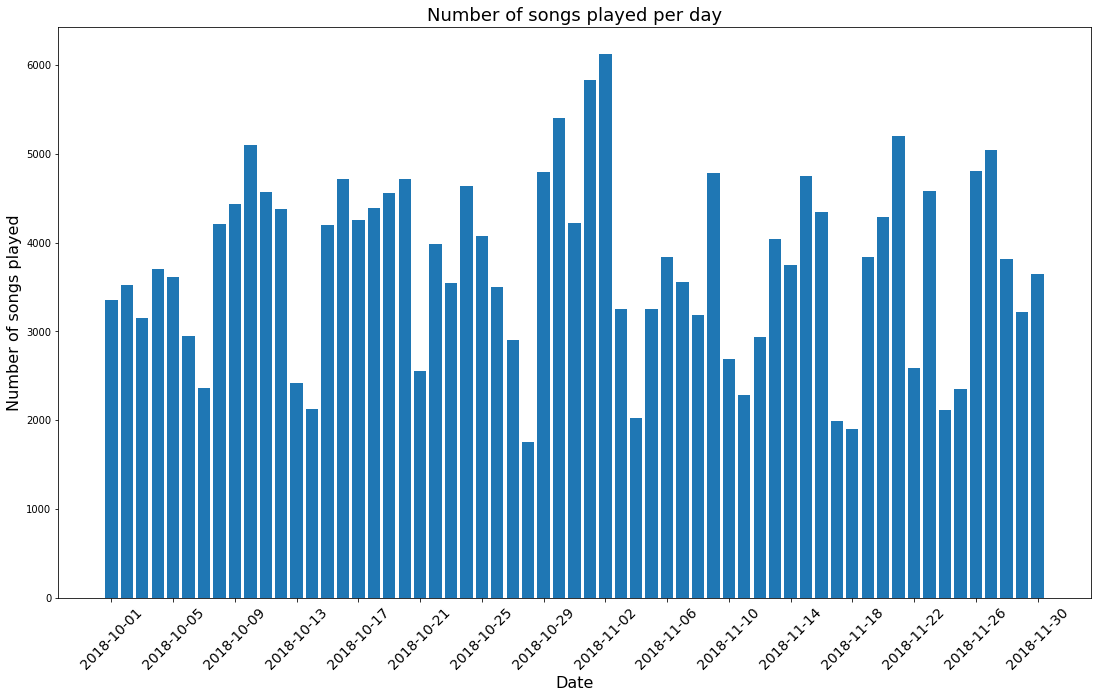

In [58]:
plt.bar(np.arange(0,61),playcount_days['playcount'])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,61,4), playcount_days['date'][::4], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played', fontsize = 16)
plt.title('Number of songs played per day', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

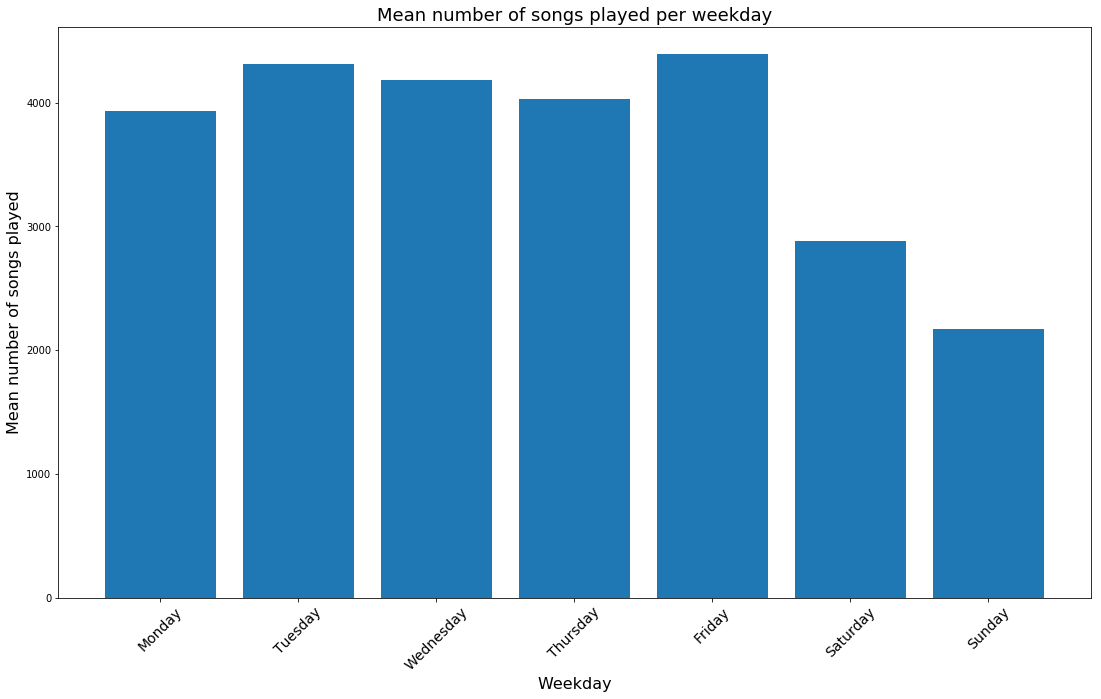

In [66]:
plt.bar(np.arange(0,7),playcount_days.groupby(['weekday'])['playcount'].mean())
plt.xlabel('Weekday', fontsize = 16)
plt.xticks(np.arange(0,7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, fontsize = 14)
plt.ylabel('Mean number of songs played', fontsize = 16)
plt.title('Mean number of songs played per weekday', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#### Let's look at unique user count over the observation period and per weekday:

In [64]:
sql_request = 'SELECT count(DISTINCT userID) AS usercount, date, MIN(weekday) AS weekday, MIN(ts) AS ts FROM log_table WHERE page = "NextSong" GROUP BY date'
usercount_days = spark.sql(sql_request).toPandas()
usercount_days = usercount_days[usercount_days['usercount']>10].sort_values(by = 'ts')

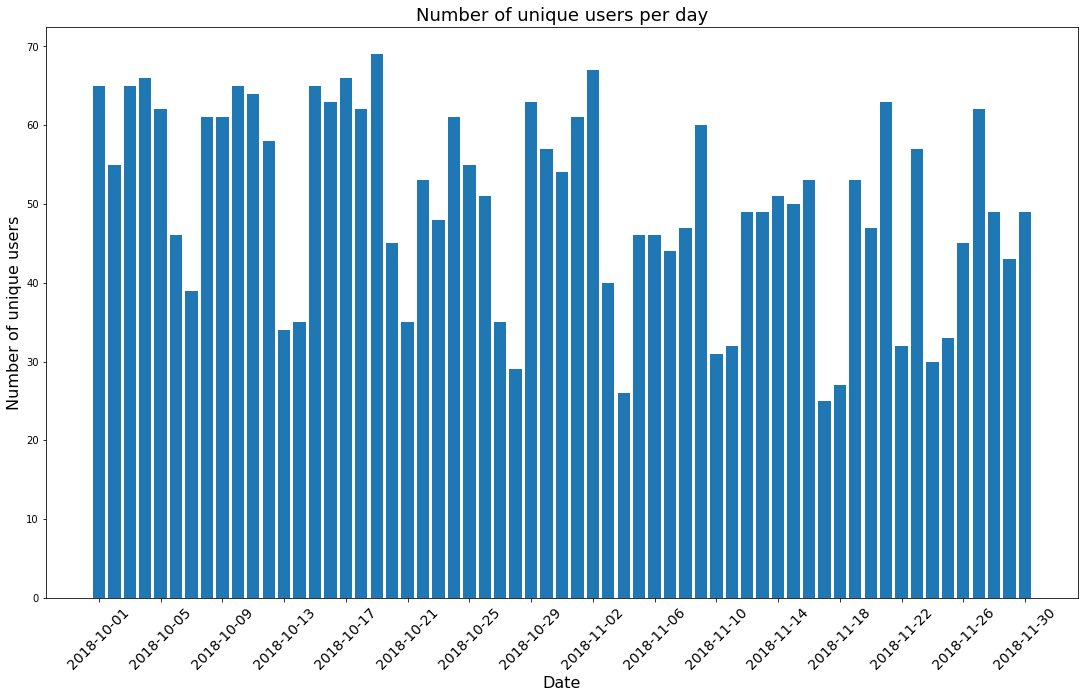

In [65]:
plt.bar(np.arange(0,61),usercount_days['usercount'])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,61,4), playcount_days['date'][::4], rotation=45, fontsize = 14)
plt.ylabel('Number of unique users', fontsize = 16)
plt.title('Number of unique users per day', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

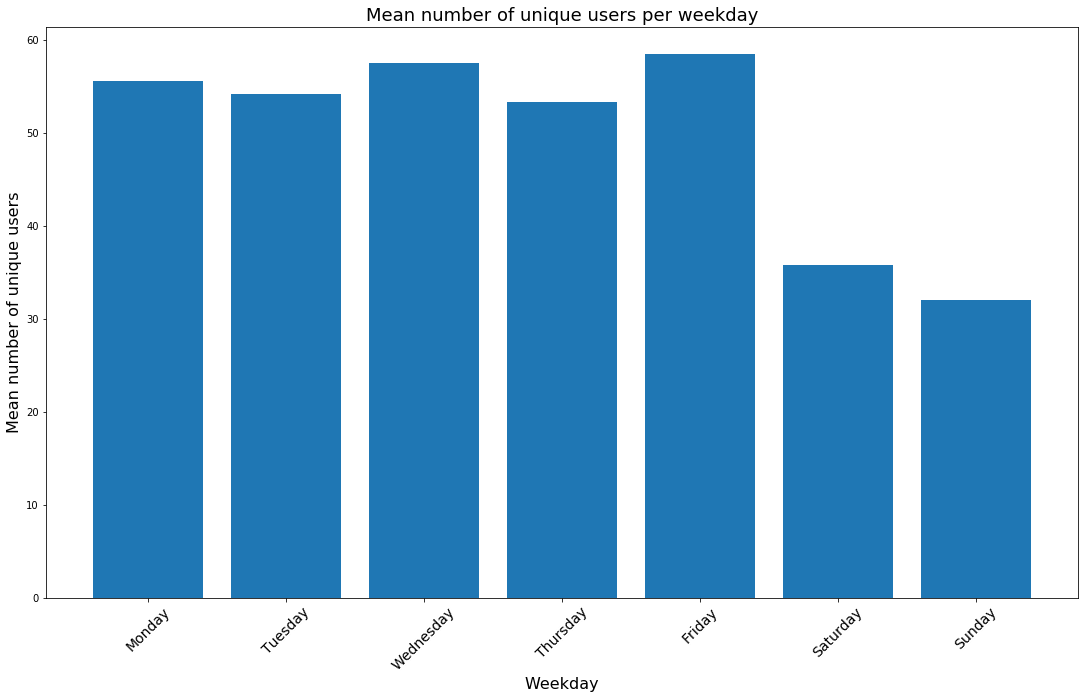

In [67]:
plt.bar(np.arange(0,7),usercount_days.groupby(['weekday'])['usercount'].mean())
plt.xlabel('Weekday', fontsize = 16)
plt.xticks(np.arange(0,7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, fontsize = 14)
plt.ylabel('Mean number of unique users', fontsize = 16)
plt.title('Mean number of unique users per weekday', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#### Let's look at songs per user over the observation period and per weekday:

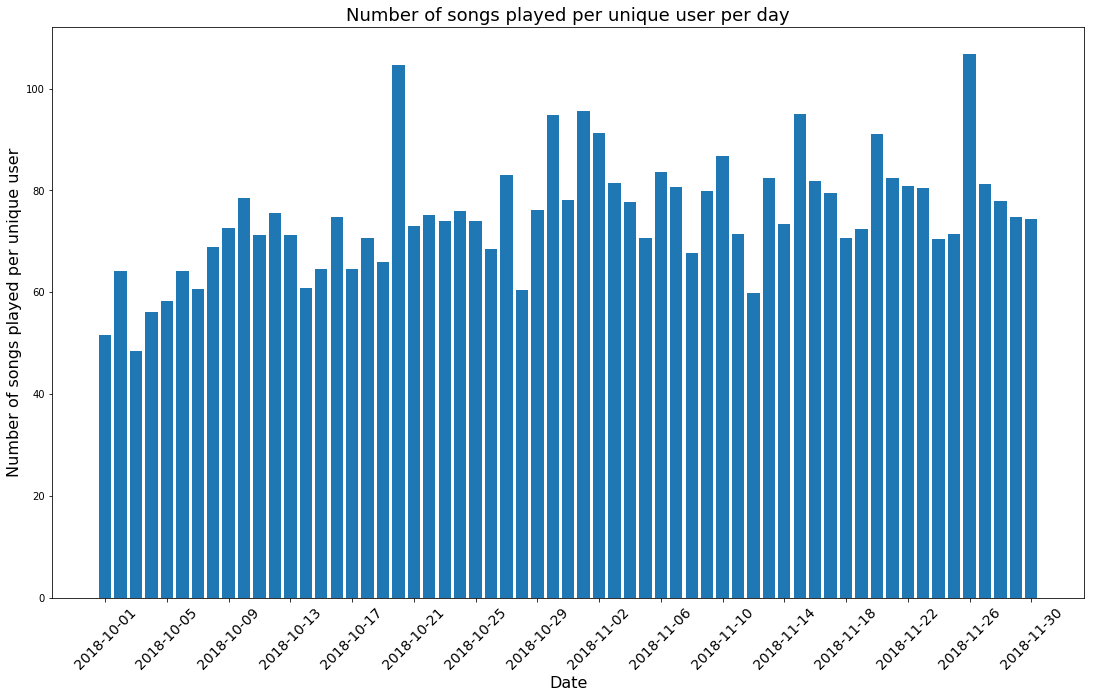

In [123]:
plt.bar(np.arange(0,61),playcount_days['playcount']/usercount_days['usercount'])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,61,4), playcount_days['date'][::4], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played per unique user', fontsize = 16)
plt.title('Number of songs played per unique user per day', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

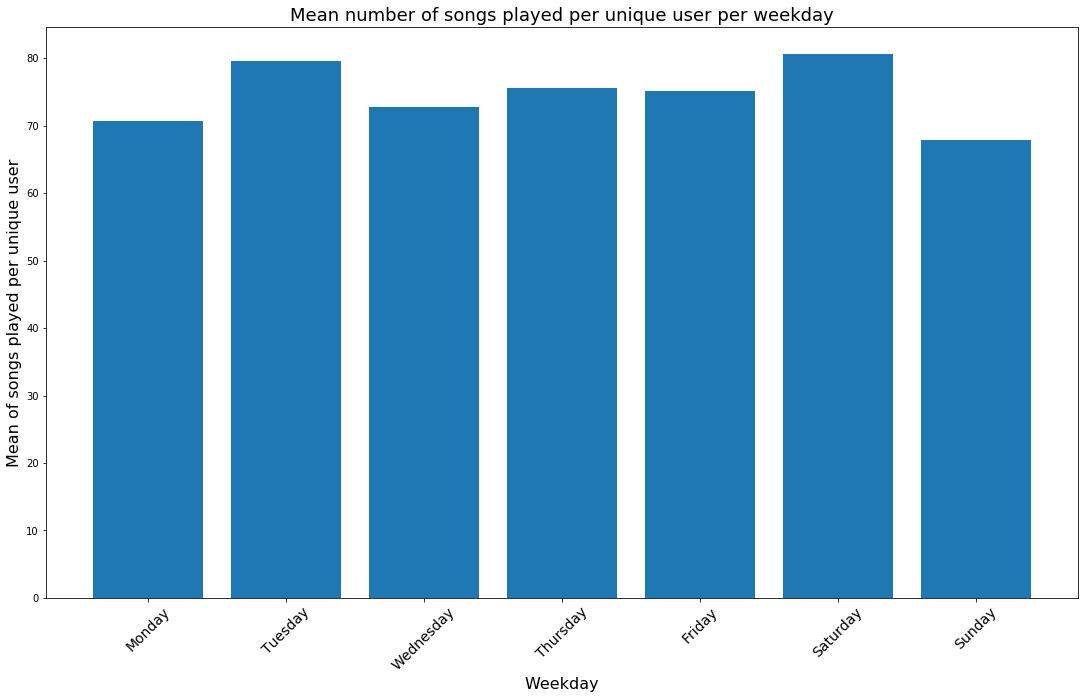

In [71]:
plt.bar(np.arange(0,7),playcount_days.groupby(['weekday'])['playcount'].mean()/usercount_days.groupby(['weekday'])['usercount'].mean())
plt.xlabel('Weekday', fontsize = 16)
plt.xticks(np.arange(0,7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, fontsize = 14)
plt.ylabel('Mean of songs played per unique user', fontsize = 16)
plt.title('Mean number of songs played per unique user per weekday', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#### Now let's look at the distribution of the user activity throughout the day.

In [88]:
sql_request = 'SELECT count(DISTINCT userID) AS usercount, count(DISTINCT date) AS daycount, hour, MIN(ts) AS ts FROM log_table WHERE page = "NextSong" GROUP BY hour'
usercount_hour = spark.sql(sql_request).toPandas()
usercount_hour = usercount_hour.sort_values(by = 'ts')

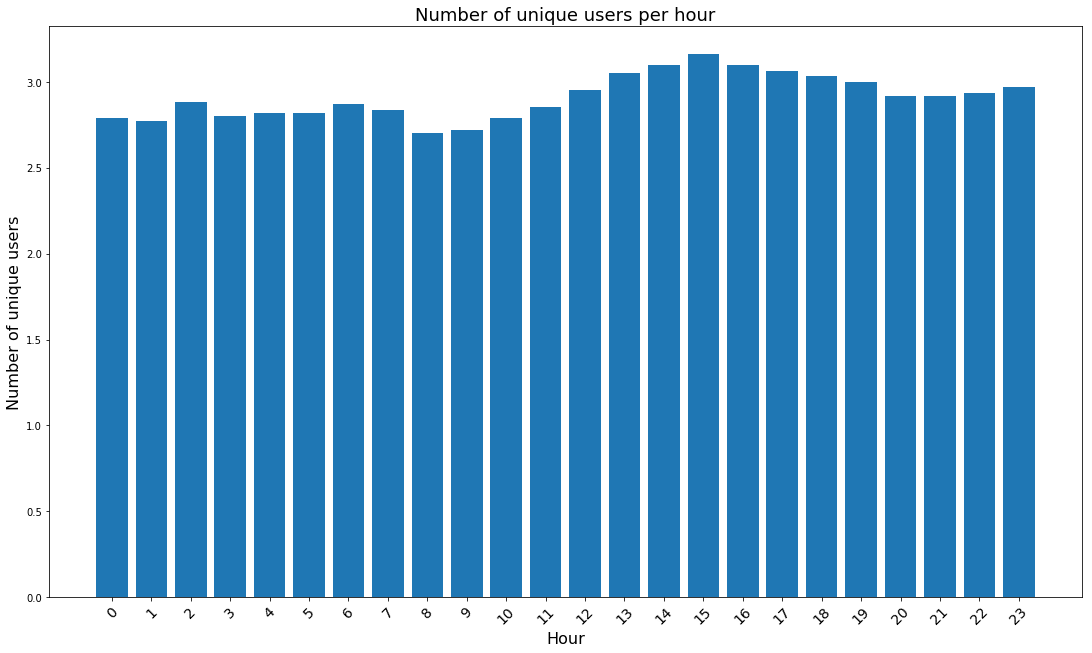

In [89]:
plt.bar(np.arange(0,24),usercount_hour['usercount']/usercount_hour['daycount'])
plt.xlabel('Hour', fontsize = 16)
plt.xticks(np.arange(0,24), usercount_hour['hour'], rotation=45, fontsize = 14)
plt.ylabel('Number of unique users', fontsize = 16)
plt.title('Number of unique users per hour', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [91]:
sql_request = 'SELECT count(DISTINCT ts) AS playcount, count(DISTINCT date) AS daycount, hour, MIN(ts) AS ts FROM log_table WHERE page = "NextSong" GROUP BY hour'
playcount_hour = spark.sql(sql_request).toPandas()
playcount_hour = playcount_hour.sort_values(by = 'ts')

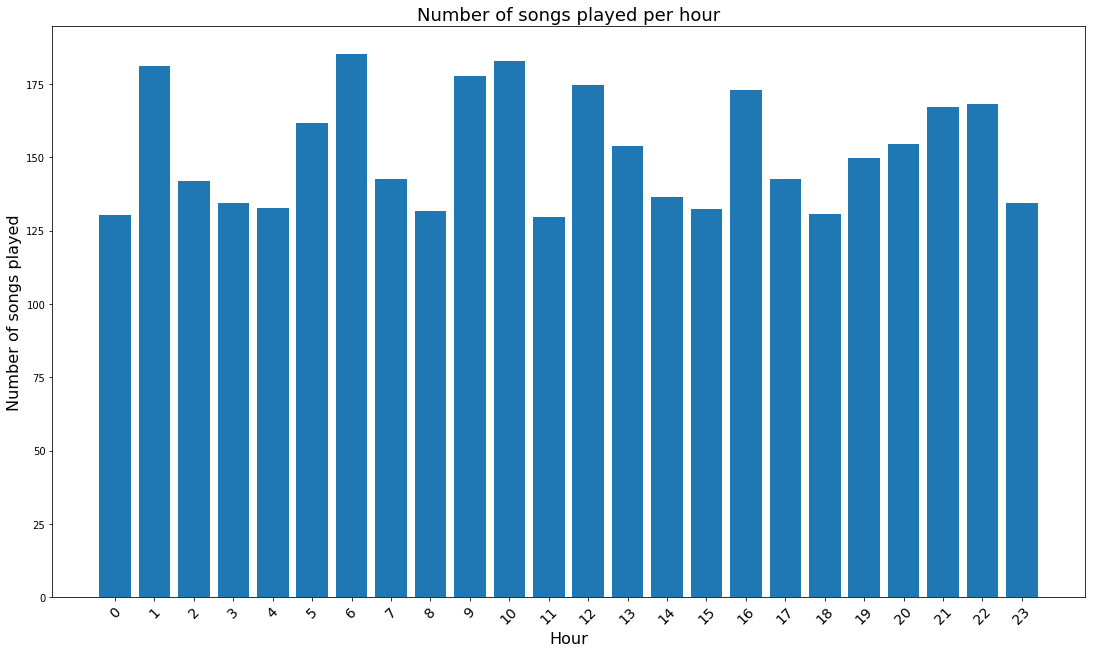

In [92]:
plt.bar(np.arange(0,24),playcount_hour['playcount']/usercount_hour['daycount'])
plt.xlabel('Hour', fontsize = 16)
plt.xticks(np.arange(0,24), playcount_hour['hour'], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played', fontsize = 16)
plt.title('Number of songs played per hour', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

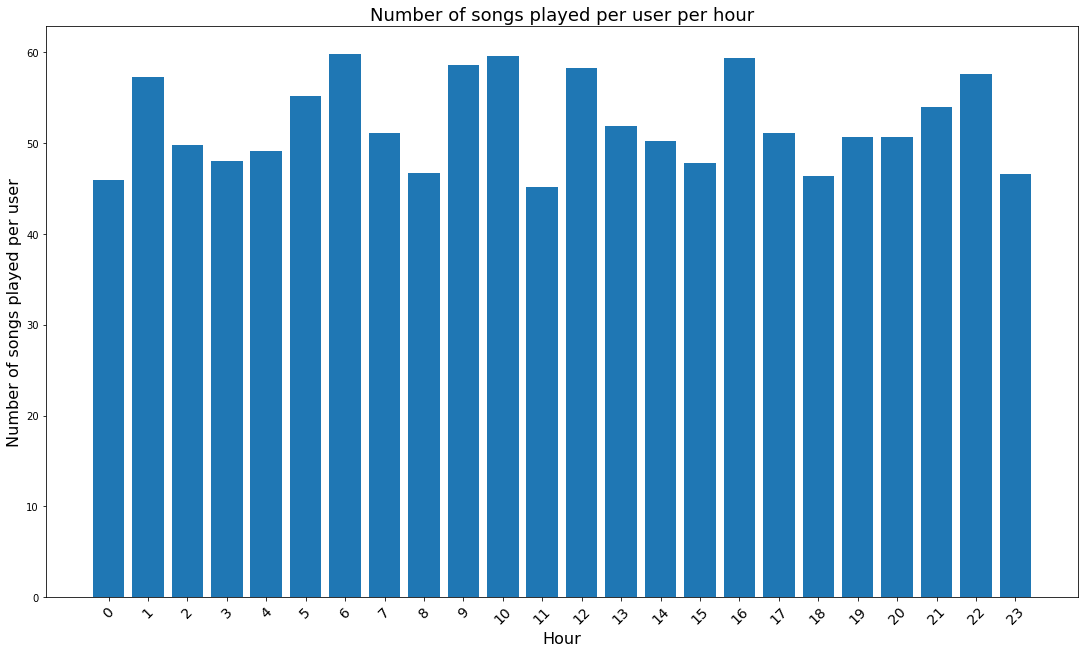

In [94]:
plt.bar(np.arange(0,24),playcount_hour['playcount']/usercount_hour['usercount'])
plt.xlabel('Hour', fontsize = 16)
plt.xticks(np.arange(0,24), playcount_hour['hour'], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played per user', fontsize = 16)
plt.title('Number of songs played per user per hour', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Summary for usage statistics

##### Let's formulate the key insights from our analysis:
* We have seen that usage statistics follow a weekly pattern with less users using Sparkify on weekends.
* Unsurprisingly there is a spike in streams around Helloween.
* Throughout the day the number of users remains almost constant with a slight increase between 1 and 7 p.m.
* The number of songs played per user throughout the day has a pattern where it follows daily activities: get up, way to work, start of work, lunchbreak etc.

##### More important is to know what we can do with this insights:
* We can optimise licence costs knowing how many songs will be played.
* We can optimise the number of servers running throughout the day and week to save electricity and networking costs based on user activity.
* We can target our user communication to the timeframes where they are most likely to use our service.

### 2. Business development

As a streaming service Sparkify has two main sources of income:
1. Paying customers
2. Advertising

Let's look how many paying customers we have throughout the observation period and how many ads were displayed.

In [115]:
sql_request = 'SELECT count(DISTINCT userID) AS paidcount, week, MIN(ts) AS ts FROM log_table WHERE level = "paid" GROUP BY week'
paid_week = spark.sql(sql_request).toPandas()
paid_week = paid_week[paid_week['paidcount']>1].sort_values(by = 'ts')
sql_request = 'SELECT count(DISTINCT userID) AS freecount, week, MIN(ts) AS ts FROM log_table WHERE level = "free" GROUP BY week'
free_week = spark.sql(sql_request).toPandas()
free_week = free_week[free_week['freecount']>1].sort_values(by = 'ts')
sql_request = 'SELECT count(DISTINCT ts) AS adscount, week, MIN(ts) AS ts FROM log_table WHERE page = "Roll Advert" GROUP BY week'
ads_week = spark.sql(sql_request).toPandas()
ads_week = ads_week.sort_values(by = 'ts')

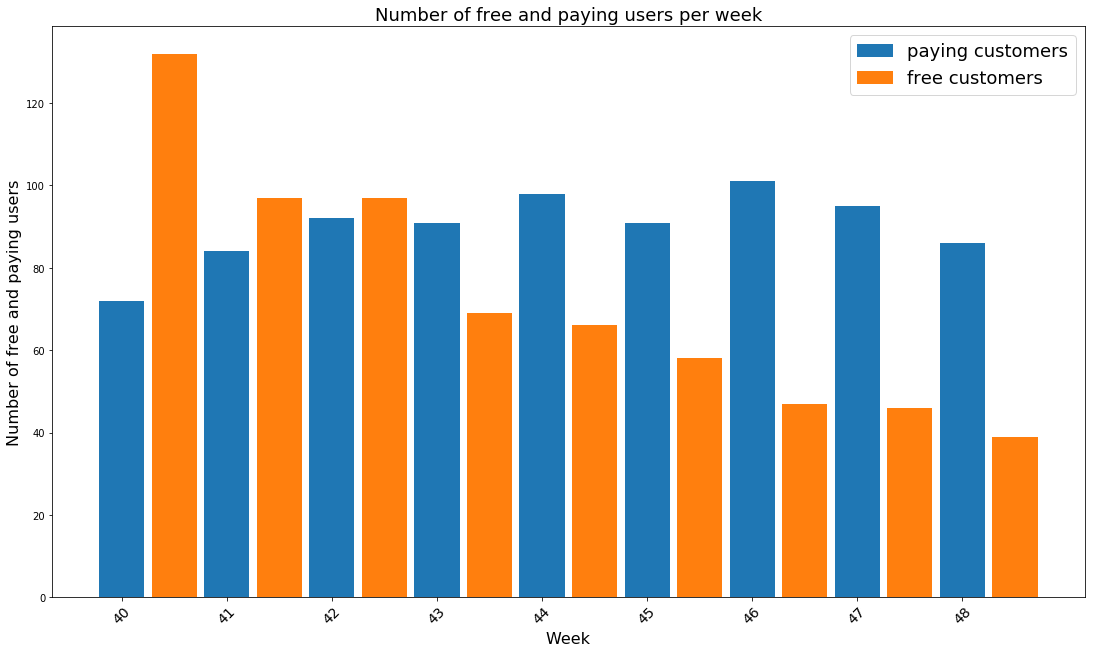

In [117]:
plt.bar(np.arange(0,9),paid_week['paidcount'], width = 0.43, label = 'paying customers')
plt.bar(np.arange(0,9) + 0.5,free_week['freecount'], width = 0.43, label = 'free customers')
plt.xlabel('Week', fontsize = 16)
plt.xticks(np.arange(0,9), upgrades_week['week'], rotation=45, fontsize = 14)
plt.ylabel('Number of free and paying users', fontsize = 16)
plt.title('Number of free and paying users per week', fontsize = 18)
plt.legend(fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

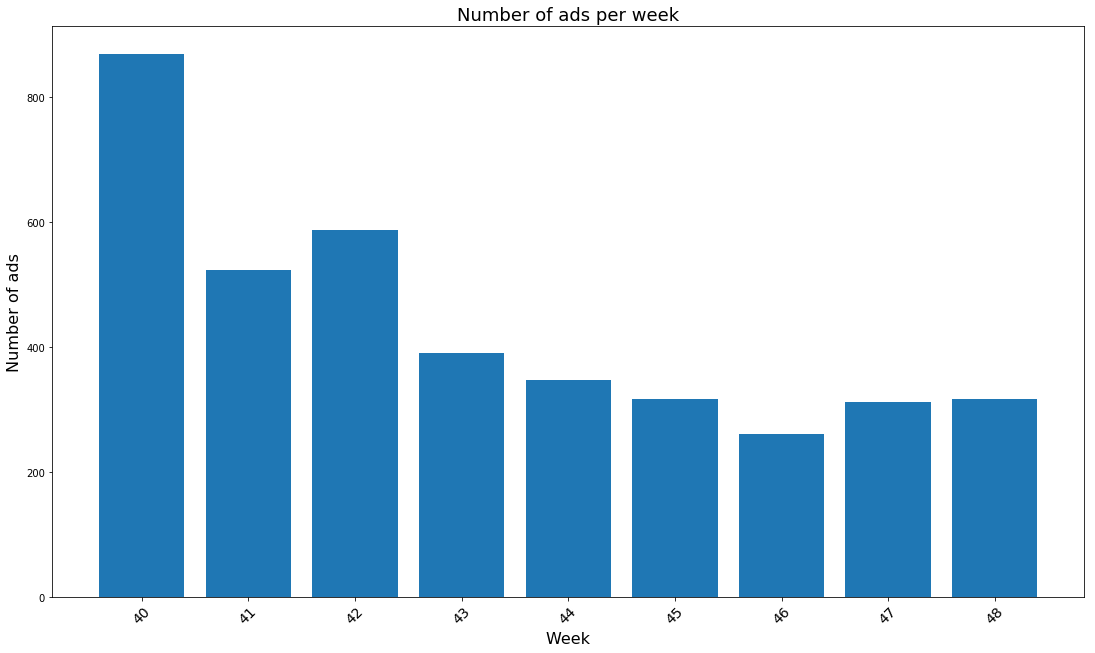

In [120]:
plt.bar(np.arange(0,9),ads_week['adscount'])
plt.xlabel('Week', fontsize = 16)
plt.xticks(np.arange(0,9), ads_week['week'], rotation=45, fontsize = 14)
plt.ylabel('Number of ads', fontsize = 16)
plt.title('Number of ads per week', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

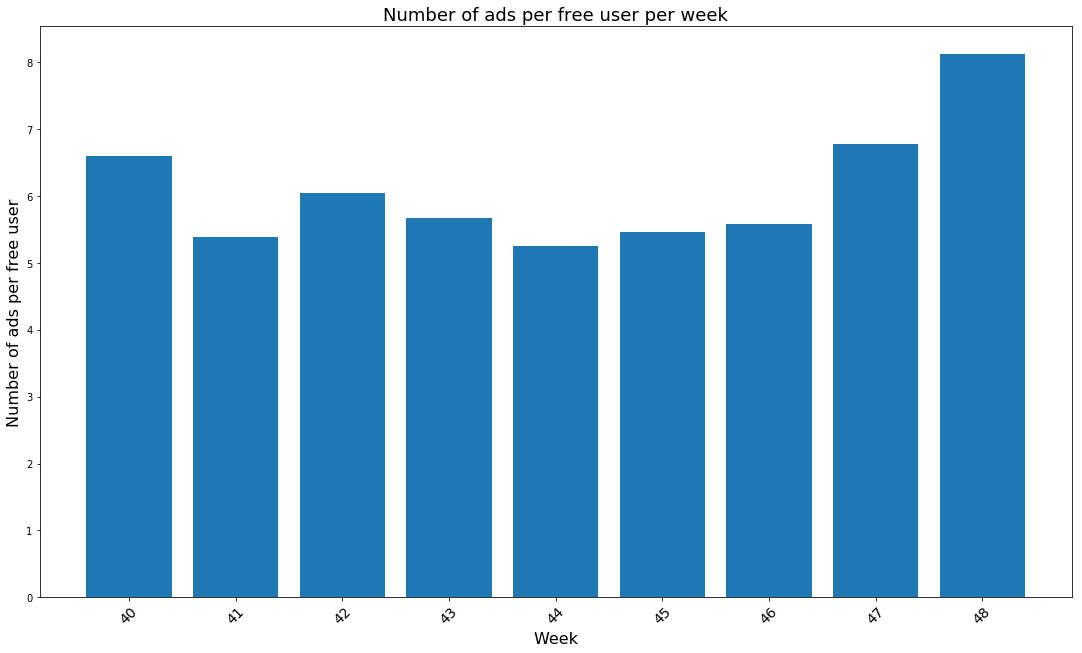

In [124]:
plt.bar(np.arange(0,9),ads_week['adscount']/free_week['freecount'])
plt.xlabel('Week', fontsize = 16)
plt.xticks(np.arange(0,9), ads_week['week'], rotation=45, fontsize = 14)
plt.ylabel('Number of ads per free user', fontsize = 16)
plt.title('Number of ads per free user per week', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Summary
Let's formulate the key insights and takeaways for our business.

##### Key insights
* The number of paying customers is increasing in the observation period.
* The number of adverts decreases.
* The number of free customers is decreasing.

##### Takeaways for business
* The number of paying customers is not changing much after the first week. Probably we need to motivate people to switch to paid account by limited time offer or free trial.
* The number of free customers is decreasing at quite high rate. It seems that the free account is not very attractive. We have to look at the reasons more closely. Are the adverts to frequent? Do free users have limited access to the music titles?
* Although the number of adverts is falling the number of adverts per user is increasing. Perhaps we have taken the wrong road here given that free users are probably choosing to leave the service over upgrading their account?

### 3. Threats to the business
Now let's look at at the dynamics of the weekly numbers of account up- and downgrades as well as cancellations. To clarify if our business development goes the right way.

In [106]:
sql_request = 'SELECT count(DISTINCT userID) AS upgradecount, week, MIN(ts) AS ts FROM log_table WHERE page = "Submit Upgrade" GROUP BY week'
upgrades_week = spark.sql(sql_request).toPandas()
upgrades_week = upgrades_week.sort_values(by = 'ts')
sql_request = 'SELECT count(DISTINCT userID) AS downgradecount, week, MIN(ts) AS ts FROM log_table WHERE page = "Submit Downgrade" GROUP BY week'
downgrades_week = spark.sql(sql_request).toPandas()
downgrades_week = downgrades_week.sort_values(by = 'ts')
sql_request = 'SELECT count(DISTINCT userID) AS cancellationscount, week, MIN(ts) AS ts FROM log_table WHERE page = "Cancellation Confirmation" GROUP BY week'
cancellations_week = spark.sql(sql_request).toPandas()
cancellations_week = cancellations_week.sort_values(by = 'ts')

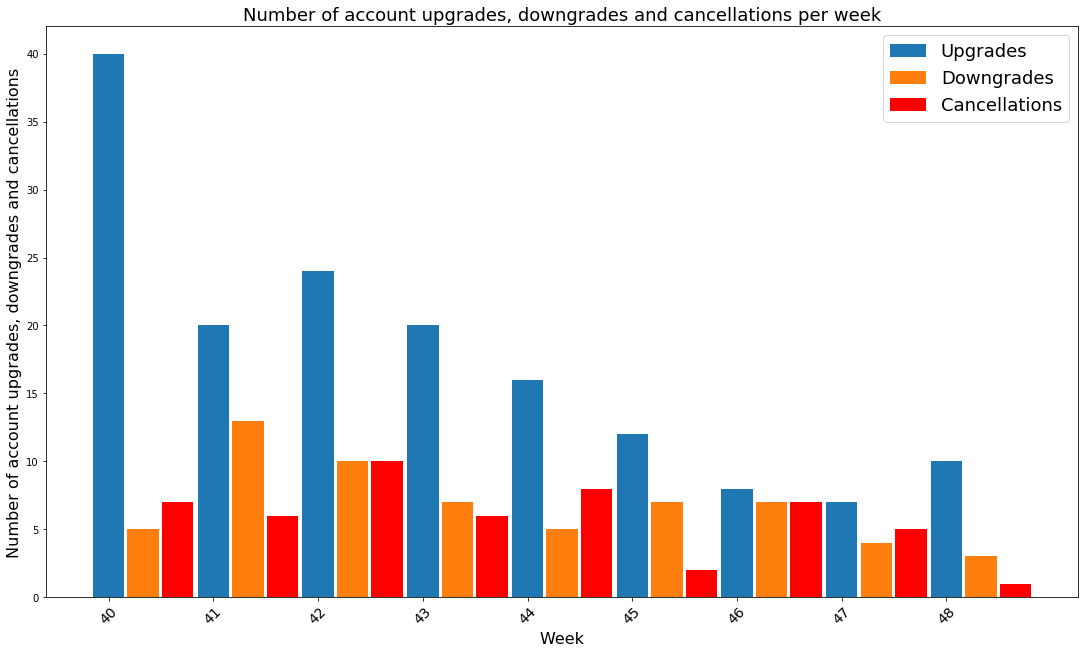

In [109]:
plt.bar(np.arange(0,9),upgrades_week['upgradecount'], width = 0.3, label = 'Upgrades')
plt.bar(np.arange(0,9) + 0.33,downgrades_week['downgradecount'], width = 0.3, label = 'Downgrades')
plt.bar(np.arange(0,9) + 0.66,cancellations_week['cancellationscount'], width = 0.3, label = 'Cancellations', color = 'red')
plt.xlabel('Week', fontsize = 16)
plt.xticks(np.arange(0,9), upgrades_week['week'], rotation=45, fontsize = 14)
plt.ylabel('Number of account upgrades, downgrades and cancellations', fontsize = 16)
plt.title('Number of account upgrades, downgrades and cancellations per week', fontsize = 18)
plt.legend(fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [130]:
cancellations = spark.sql('''SELECT level, count(DISTINCT userID) AS number_cancelled \
        FROM log_table WHERE page = "Cancellation Confirmation" GROUP BY level''').toPandas()

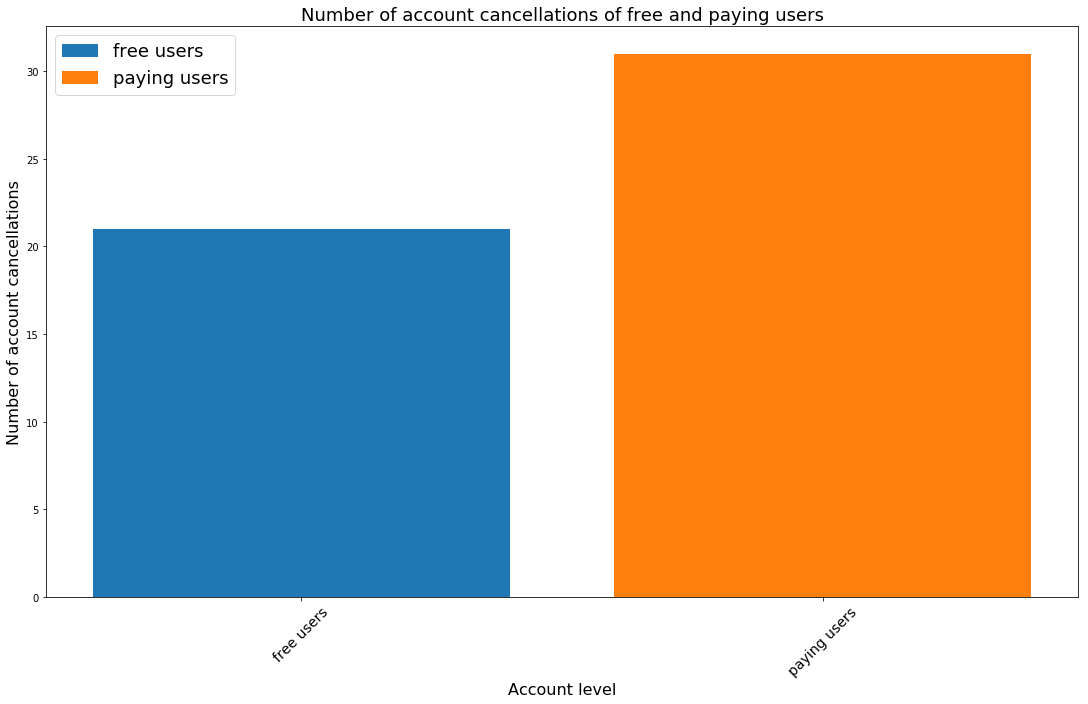

In [129]:
plt.bar([0],cancellations['number_cancelled'][0], label = 'free users')
plt.bar([1],cancellations['number_cancelled'][1], label = 'paying users')
plt.xlabel('Account level', fontsize = 16)
plt.xticks([0, 1], ['free users', 'paying users'], rotation=45, fontsize = 14)
plt.ylabel('Number of account cancellations', fontsize = 16)
plt.title('Number of account cancellations of free and paying users', fontsize = 18)
plt.legend(fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Summary
Let's formulate the key insights and takeaways for our business.

##### Key insights
* The number of upgrades spiked in the first week of observation.
* The number of upgrades is declining during the period of observation.
* The number of downgrades has a small spike in the week 41 and is almost steady with decline near the end.
* The number of cancellations is almost steady with a small spike around week 42 and decline near the end.
* Paying users are cancelling their accounts more often then free users.

##### Takeaways for business
* Whatever we have done in the week 40 we must keep doing that!
* We need to understand why less and less customers choose to upgrade their accounts.
* Although the downgrade and cancellation rates are falling we need pay more attention to them.
* The fact that paying users are choosing to cancel their account rather than to downgrade them is alarming.

## Explorative Data Analysis

This function will give an overview of distinct value counts and their distribution if the number of distinct values is smaller than 20.

In [16]:
def show_distinct_counts(column_name, table_name = 'log_table'):
    """Shows counts of distinct values of a column in an sql table.
    If the number of distinct values is smaller than 20 then
    counts for each value are displayed. Otherwise only the total
    number of distinct values is presented.
    
    INPUT:
        column_name (str): name of the column
        table_name (str): name of the table
        
    OUTPUT:
        none
    """
    n_distinct = spark.sql('SELECT COUNT(DISTINCT {}) AS count FROM {}'.format(column_name, table_name)).first()[0]
    #print(n_distinct)
    
    if n_distinct<=20:
        sql_query = 'SELECT {0}, count({0}) AS {0}_counts FROM {1} GROUP BY {0}'.format(column_name, table_name)
    else:
        sql_query = 'SELECT COUNT(DISTINCT {0}) AS Distinct_count_{0} FROM {1}'.format(column_name, table_name)
        
    spark.sql(sql_query).show()   

Let's apply this function to the dataframe's columns to get an overview of the data:

In [17]:
for column in df.columns:
    show_distinct_counts(column)

+---------------------+
|Distinct_count_artist|
+---------------------+
|                17655|
+---------------------+

+---------+-----------+
|     auth|auth_counts|
+---------+-----------+
|Cancelled|         52|
|Logged In|     278102|
+---------+-----------+

+------------------------+
|Distinct_count_firstName|
+------------------------+
|                     189|
+------------------------+

+------+-------------+
|gender|gender_counts|
+------+-------------+
|     F|       154578|
|     M|       123576|
+------+-------------+

+----------------------------+
|Distinct_count_itemInSession|
+----------------------------+
|                        1311|
+----------------------------+

+-----------------------+
|Distinct_count_lastName|
+-----------------------+
|                    173|
+-----------------------+

+---------------------+
|Distinct_count_length|
+---------------------+
|                14865|
+---------------------+

+-----+------------+
|level|level_counts|
+-----+--

This method didn't provide the results we wanted for gender and level. Let's do some extra evaluation for these columns.

First let's look at the gender distribution:

In [18]:
spark.sql(''' SELECT gender, count(DISTINCT userID) AS gender_counts FROM log_table GROUP BY gender ''').show()

+------+-------------+
|gender|gender_counts|
+------+-------------+
|     F|          104|
|     M|          121|
+------+-------------+



Let's see how many users changed their level:

In [19]:
spark.sql(''' SELECT levels AS level_counts, count(levels) AS users \
        FROM (SELECT count(DISTINCT level) AS levels \
        FROM log_table GROUP BY userID) GROUP BY levels ''').show()

+------------+-----+
|level_counts|users|
+------------+-----+
|           1|   90|
|           2|  135|
+------------+-----+



And how many users get their subscription cancelled:

In [20]:
spark.sql(''' SELECT auth, count(DISTINCT userID) AS auth_counts FROM log_table GROUP BY auth ''').show()

+---------+-----------+
|     auth|auth_counts|
+---------+-----------+
|Cancelled|         52|
|Logged In|        225|
+---------+-----------+



### The suggestion was to define churn as following events:
1. Customer cancelled account.
2. Customer downgraded account.

The first case is easier to track. Since the number of cancelled auth and visits to "Cancellation Confirmation" page is same, we can assume, that after visiting the page and getting the cancelled auth the users have cancelled their accounts.

The second case is more complicated and ambiguous, because the user behaviour of someone who downgraded their account may not be different from that of a paying user.They may choose to downgrade because they don't use the service frequently or just don't have the financial ability to pay for higher level service. Also let's keep in mind that we still generate revenue from free level users by rolling ads.

### In this notebook we define churn as account cancellation.

In [134]:
get_churn_cancel = udf(lambda x: int(x=='Cancellation Confirmation'), IntegerType())
df = df.withColumn('churn_cancelled', get_churn_cancel('page'))
df.createOrReplaceTempView("log_table")

### Outliers

#### Early churn
If a user cancelled account in a timeframe less than a five days from beginning of observations we are dealing with early churn. In this case this user's data will not be compareable to others.

In [219]:
# let's find early churn users:
early_churn = spark.sql(''' SELECT userID, ts FROM log_table WHERE churn_cancelled = 1 ''').toPandas()
early_churn.sort_values('ts', inplace = True)
early_churn[early_churn['ts'] < ts_begin + 3600*24*5*1000]
early_churn = early_churn[early_churn['ts'] < ts_begin + 3600*24*5*1000]
list_remove = early_churn.userID.tolist()

#### Non-use
Some customers have very low interaction level. It is possible that they do not use the service at all. Keeping them in the analysis will skew the distribution of our features. We will assume that users with less than one interaction per day on average are effectively not using our service.

In [220]:
usage_statistic = spark.sql(''' SELECT userID, count(ts) AS interactions, MAX(churn_cancelled) AS churn FROM log_table GROUP BY userID ''').toPandas()

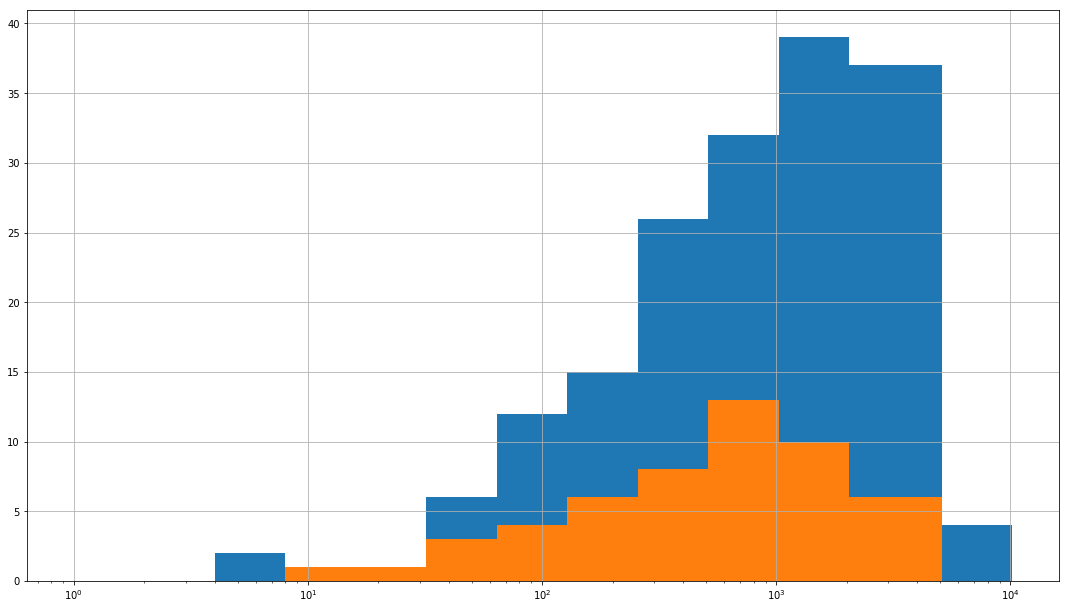

In [221]:
usage_statistic.groupby('churn')['interactions'].hist(bins = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 5096, 10192])
plt.xscale('log')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [222]:
non_users = usage_statistic[usage_statistic['interactions']<60].userID.tolist()
list_remove.extend([x for x in non_users if not x in list_remove])

In [223]:
print('We will have to remove {} users from our analysis due to early churn or to low usage.'.format(len(list_remove)))
print('User IDs: ', ' '.join(list_remove))

We will have to remove 14 users from our analysis due to early churn or to low usage.
User IDs:  100011 100001 100024 300007 100006 125 133 22 90 68 135 156 300003 134


# Feature Engineering

##### Methodology
It may seem to plausible to involve such factors as browser, platform, location or gender in the prediction of churn. These factors may lead to churn, but they are affecting certain groups of customers and are not related to individual customer experience. Therefore they will not help us to predict churn, but rather indicate which customer groups may be more dissatisfied with our service.

In this analysis we will focus on user specific factors such as:
 * number of songs played
 * number of different songs played
 * number of different artists
 * number of sessions
 * number of upgrades
 * number of downgrades
 * page visits
     * downgrade
     * upgrade
     * thumbs down
     * thumbs up
     * roll advert
     * home
     * logout
     * settings
     * save settings
     * add to playlist
     * help
     * error
     * about
     * add friend

In [25]:
df_churn = spark.sql('''
SELECT userID, count(song) AS song_count, \
count(DISTINCT song) AS dist_song_count, \
count(DISTINCT artist) AS dist_artist_count, \
count(DISTINCT sessionId) AS session_count, \
count(CASE WHEN page = "Submit Downgrade" THEN 1 END) AS downgrade_count, \
count(CASE WHEN page = "Submit Upgrade" THEN 1 END) AS upgrade_count, \
count(CASE WHEN page = "Cancellation Confirmation" THEN 1 END) AS churn, \
count(CASE WHEN page = "Home" THEN 1 END) AS page_visits_home, \
count(CASE WHEN page = "Logout" THEN 1 END) AS page_visits_logout, \
count(CASE WHEN page = "Settings" THEN 1 END) AS page_visits_settings, \
count(CASE WHEN page = "Save Settings" THEN 1 END) AS page_visits_save_settings, \
count(CASE WHEN page = "Thumbs Down" THEN 1 END) AS page_visits_thumbs_down, \
count(CASE WHEN page = "Thumbs Up" THEN 1 END) AS page_visits_thumbs_up, \
count(CASE WHEN page = "Upgrade" THEN 1 END) AS page_visits_upgrade, \
count(CASE WHEN page = "Downgrade" THEN 1 END) AS page_visits_downgrade, \
count(CASE WHEN page = "Roll Advert" THEN 1 END) AS page_visits_roll_advert, \
count(CASE WHEN page = "About" THEN 1 END) AS page_visits_about, \
count(CASE WHEN page = "Add to Playlist" THEN 1 END) AS page_visits_add_to_playlist, \
count(CASE WHEN page = "Add Friend" THEN 1 END) AS page_visits_add_friend, \
count(CASE WHEN page = "Help" THEN 1 END) AS page_visits_help, \
count(CASE WHEN page = "Error" THEN 1 END) AS page_visits_error \
FROM log_table GROUP BY userID ''').toPandas()

In [26]:
# let's look at the counts
df_churn.iloc[:10,:8]

,userID,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn
0,100010,275,269,252,7,0,0,0
1,200002,387,378,339,6,0,1,0
2,125,8,8,8,1,0,0,1
3,51,2111,1854,1385,10,0,0,1
4,124,4079,3339,2232,29,0,0,0
5,7,150,148,142,7,0,0,0
6,54,2841,2414,1744,37,1,1,1
7,15,1914,1707,1302,15,0,0,0
8,155,820,759,643,6,0,1,0
9,132,1928,1718,1299,16,0,1,0


In [27]:
# let's look at the page visits
df_churn.iloc[:10,7:]

,churn,page_visits_home,page_visits_logout,page_visits_settings,page_visits_save_settings,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
0,0,11,5,0,0,5,17,2,0,52,1,7,4,2,0
1,0,20,5,3,0,6,21,2,5,7,3,8,4,2,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,75,24,12,1,21,100,0,23,0,2,52,28,12,1
4,0,176,59,20,6,41,171,0,41,4,7,118,74,23,6
5,0,10,3,3,1,1,7,2,0,16,0,5,1,1,1
6,1,129,36,17,3,29,163,1,39,47,5,72,33,17,1
7,0,93,27,16,2,14,81,0,28,1,2,59,31,8,2
8,0,30,14,5,0,3,58,2,12,8,2,24,11,9,3
9,0,83,34,17,4,17,96,1,19,2,4,38,41,16,3


As discussed before we will remove users, who churned in less than one week.

In [28]:
df_churn = df_churn[~df_churn.userID.isin(list_remove)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbdc735a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcbdcd229e8>]], dtype=object)

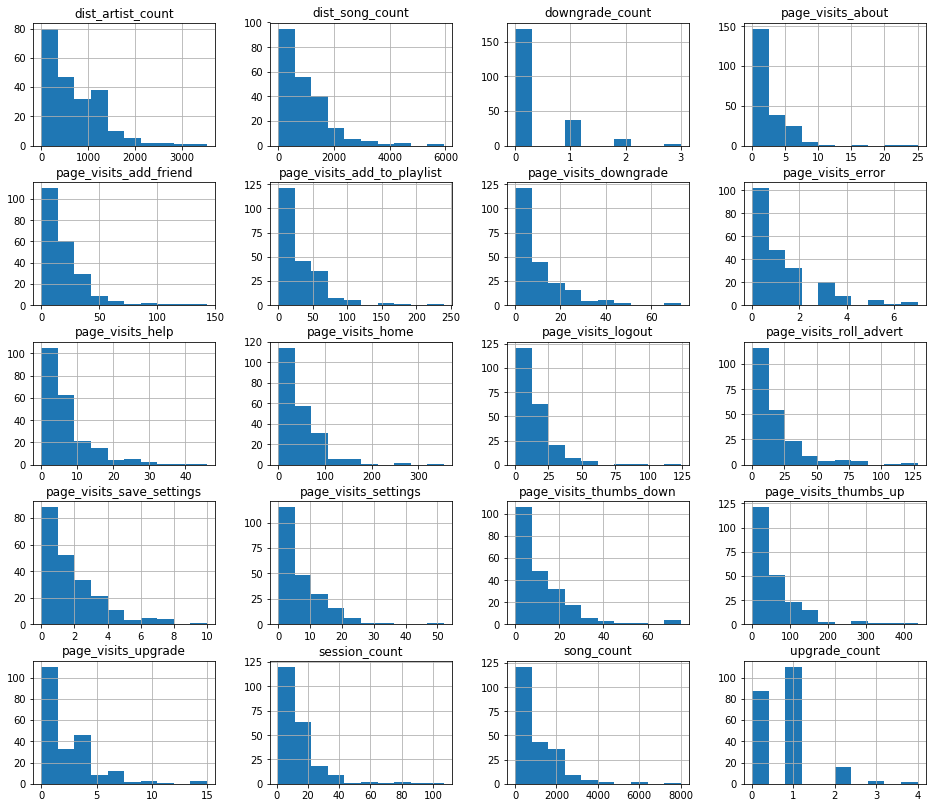

In [29]:
df_churn.drop(columns = ['churn']).hist(figsize = (16,14))

Let's rescale the statistics with the number of sessions.

In [30]:
df_div = df_churn.copy(deep = True)
df_div.iloc[:,1:4] = df_div.iloc[:,1:4].div(df_div.session_count, axis=0)
df_div.iloc[:,8:] = df_div.iloc[:,8:].div(df_div.session_count, axis=0)

In [31]:
df_div.describe()

,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn,page_visits_home,page_visits_logout,page_visits_settings,...,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,...,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,69.815479,64.206574,53.355827,14.495413,0.288991,0.729358,0.206422,3.146716,1.028254,0.484892,...,0.766735,3.745666,0.196105,0.577022,1.611608,0.154460,1.940166,1.366555,0.438610,0.084908
std,42.346979,37.811378,30.167894,14.720201,0.594884,0.734383,0.405668,1.575141,0.698332,0.423177,...,0.588750,2.278660,0.240154,0.578931,1.784380,0.201838,1.277408,0.909917,0.333966,0.130685
min,3.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.811304,36.495798,32.694079,6.000000,0.000000,0.000000,0.000000,2.067857,0.673077,0.235994,...,0.376488,2.119518,0.030357,0.000000,0.333333,0.000000,1.000000,0.750000,0.203526,0.000000
50%,64.750000,59.520833,48.522282,10.000000,0.000000,1.000000,0.000000,2.904545,1.000000,0.409007,...,0.666667,3.500000,0.142857,0.454545,1.026316,0.116516,1.804762,1.263889,0.388889,0.037088
75%,91.778571,84.488487,66.151989,18.000000,0.000000,1.000000,0.000000,3.902406,1.250000,0.661765,...,1.000000,5.000000,0.272727,0.898214,2.333333,0.216667,2.623162,1.800000,0.587518,0.124053
max,286.666667,246.444444,197.000000,107.000000,3.000000,4.000000,1.000000,11.000000,8.000000,4.000000,...,3.466667,13.777778,2.000000,2.444444,14.000000,2.000000,8.000000,4.666667,2.000000,1.000000


We will use StandardScaler to scale the parameters.

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles = 1000, output_distribution = 'uniform')
df_div.iloc[:,1:7] = scaler.fit_transform(df_div.iloc[:,1:7])
df_div.iloc[:,8:] = scaler.fit_transform(df_div.iloc[:,8:])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbdc9b1940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcbcfb8a828>]], dtype=object)

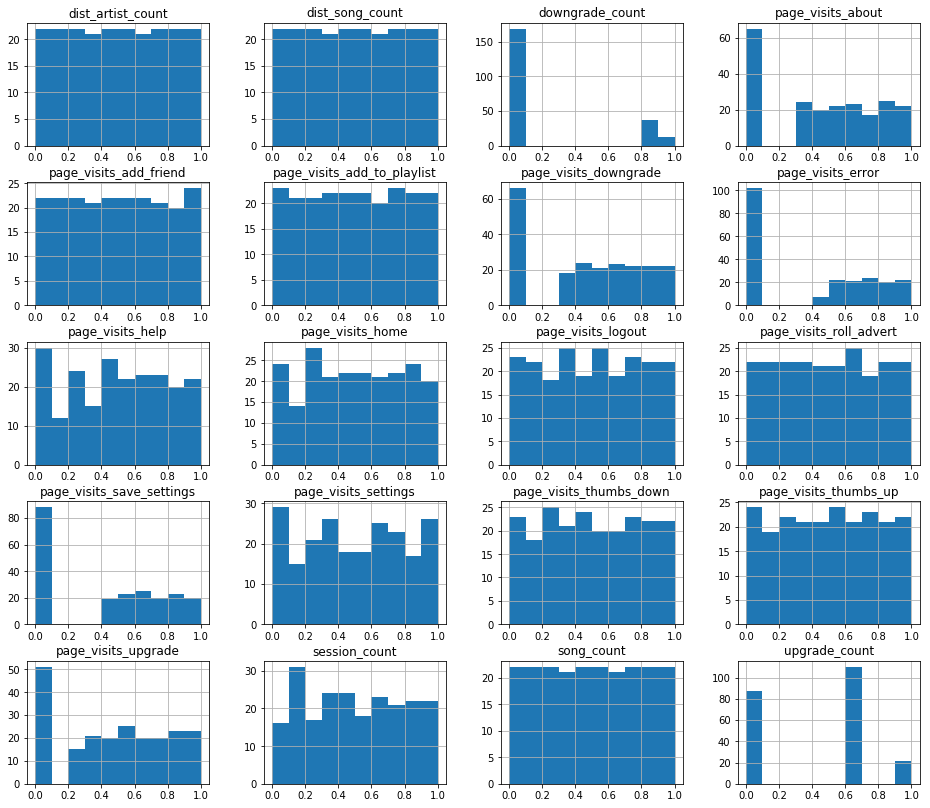

In [33]:
df_div.drop(columns = ['churn']).hist(figsize = (16,14))

In [34]:
df_div.describe()

,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn,page_visits_home,page_visits_logout,page_visits_settings,...,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
count,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,218.000000,2.180000e+02,2.180000e+02,2.180000e+02,...,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02
mean,5.000038e-01,5.000080e-01,4.999991e-01,4.988394e-01,1.999477e-01,4.209439e-01,0.206422,5.000091e-01,4.992681e-01,4.915100e-01,...,4.956118e-01,4.998438e-01,4.730484e-01,4.547266e-01,4.970702e-01,4.560776e-01,4.993160e-01,4.971898e-01,4.909607e-01,3.911659e-01
std,2.906726e-01,2.906648e-01,2.906691e-01,2.923399e-01,3.729123e-01,3.544815e-01,0.405668,2.906316e-01,2.916876e-01,3.036311e-01,...,2.975703e-01,2.908774e-01,3.264605e-01,3.446757e-01,2.952590e-01,3.434256e-01,2.918430e-01,2.953392e-01,3.044911e-01,3.845617e-01
min,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.000000,1.000000e-07,1.000000e-07,1.000000e-07,...,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
25%,2.501877e-01,2.502069e-01,2.499211e-01,2.537538e-01,1.000000e-07,1.000000e-07,0.000000,2.501878e-01,2.394792e-01,2.501600e-01,...,2.499855e-01,2.502450e-01,2.498276e-01,1.000000e-07,2.582583e-01,1.000000e-07,2.422422e-01,2.532533e-01,2.498343e-01,1.000000e-07
50%,4.999237e-01,4.999409e-01,5.000276e-01,4.864865e-01,1.000000e-07,6.521522e-01,0.000000,4.998980e-01,5.485485e-01,5.000194e-01,...,4.929930e-01,5.000000e-01,5.090090e-01,5.010010e-01,4.919514e-01,5.000344e-01,4.993084e-01,5.000893e-01,5.000000e-01,5.010358e-01
75%,7.500755e-01,7.499759e-01,7.497797e-01,7.467467e-01,1.000000e-07,6.521522e-01,0.000000,7.502015e-01,7.467467e-01,7.548799e-01,...,7.307307e-01,7.532533e-01,7.487487e-01,7.499904e-01,7.487487e-01,7.478729e-01,7.500581e-01,7.467467e-01,7.497890e-01,7.605824e-01
max,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,1.000000,9.999999e-01,9.999999e-01,9.999999e-01,...,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 1. Supervised learning
Supervised learning algorithms train classifiers based on known input - output pairs. To evaluate the results the data must be split into training and testing data. To comapre different models we will use validation data.

In [35]:
# the number of users is low and the number of those who churned even lower
# let's repeat the splitting as long as we don't have at least 20% of churned users in both test and validate datasets
train, validate, test = np.split(df_div.sample(frac=1), [int(.6*len(df_div)), int(.8*len(df_div))])
while (len(validate[validate['churn']==1]) < len(df_div[df_div['churn']==1]) // 5) or \
        (len(test[test['churn']==1]) < len(df_div[df_div['churn']==1]) // 5) or \
        (len(test[test['churn']==1]) != len(validate[validate['churn']==1])):
        train, validate, test = np.split(df_div.sample(frac=1), [int(.6*len(df_div)), int(.8*len(df_div))])

In [36]:
X_val = validate.drop(columns = ['userID', 'churn'])
y_val = validate['churn']

X_test = test.drop(columns = ['userID', 'churn'])
y_test = test['churn']

X_train = train.drop(columns = ['userID', 'churn'])
y_train = train['churn']

We are dealing with imbalanced classes here. One way to account for that would be to downsample the majority class. This is  an easy way to balance data, but it also reduces the variability in the majority class and therefore the classifiers may be biased. For this reason we will upsample the minority class in the training data.

In [37]:
X_train = X_train.append(X_train[y_train == 1]).append(X_train[y_train == 1]).append(X_train[y_train == 1])
y_train = y_train.append(y_train[y_train == 1]).append(y_train[y_train == 1]).append(y_train[y_train == 1])

#### 1.1. Decision Tree

In [38]:
from sklearn import tree


In [39]:
tree_clf = tree.DecisionTreeClassifier(random_state=42)
ts = time.time()
tree_clf.fit(X_train, y_train)
tree_train_time = time.time() - ts

In [40]:
ts = time.time()
y_pred_tree = tree_clf.predict(X_test)
tree_predict_time = time.time() - ts

In [41]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [42]:
f1_tree = f1_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
print('Decision tree metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_tree, precision_tree, recall_tree))

Decision tree metrics:
 f1: 0.3157894736842105
 precision: 0.3333333333333333
 recall: 0.3


Text(0,0.5,'True')

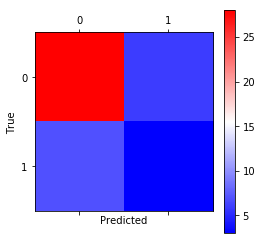

In [43]:
tree_conf_mat = confusion_matrix(y_test, y_pred_tree).astype('float64') 
plt.matshow(tree_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.2. Bagging algorithm: Random Forest
Random Forest creates multiple decision trees and counts their outputs as votes to classify a given data point.

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rf_clf = RandomForestClassifier(random_state = 42)
ts = time.time()
rf_clf.fit(X_train, y_train)
rf_train_time = time.time() - ts

In [46]:
ts = time.time()
y_pred_rf = rf_clf.predict(X_test)
rf_predict_time = time.time() - ts

In [47]:
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
print('Random forest metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_rf, precision_rf, recall_rf))

Random forest metrics:
 f1: 0.125
 precision: 0.16666666666666666
 recall: 0.1


Text(0,0.5,'True')

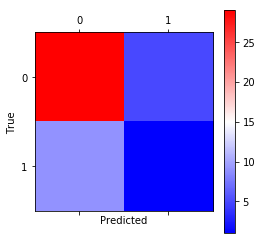

In [48]:
rf_conf_mat = confusion_matrix(y_test, y_pred_rf).astype('float64') 
plt.matshow(rf_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.3. Boosting algorithm: AdaBoost

In [49]:
from sklearn.ensemble import AdaBoostClassifier

In [50]:
ada_clf = AdaBoostClassifier(random_state = 42)
ts = time.time()
ada_clf.fit(X_train, y_train)
ada_train_time = time.time() - ts

In [51]:
ts = time.time()
y_pred_ada = ada_clf.predict(X_test)
ada_predict_time = time.time() - ts

In [52]:
f1_ada = f1_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
print('AdaBoost metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_ada, precision_ada, recall_ada))

AdaBoost metrics:
 f1: 0.28571428571428564
 precision: 0.2727272727272727
 recall: 0.3


Text(0,0.5,'True')

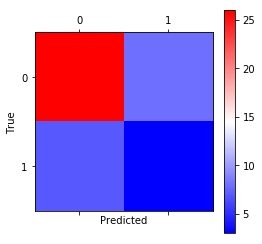

In [53]:
ada_conf_mat = confusion_matrix(y_test, y_pred_ada).astype('float64') 
plt.matshow(ada_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.4. Neural Network: Multi-Layer Perceptron

In [54]:
from sklearn.neural_network import MLPClassifier

In [55]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(7), random_state = 42, early_stopping = True)
ts = time.time()
mlp_clf.fit(X_train, y_train)
mlp_train_time = time.time() - ts

In [56]:
ts = time.time()
y_pred_mlp = mlp_clf.predict(X_test)
mlp_predict_time = time.time() - ts

In [57]:
f1_mlp = f1_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
print('Multi-Layer Perceptron metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_mlp, precision_mlp, recall_mlp))

Multi-Layer Perceptron metrics:
 f1: 0.37735849056603776
 precision: 0.23255813953488372
 recall: 1.0


Text(0,0.5,'True')

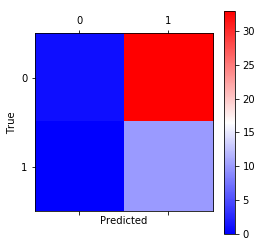

In [58]:
mlp_conf_mat = confusion_matrix(y_test, y_pred_mlp).astype('float64') 
plt.matshow(mlp_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.5. Gaussian Naive Bayes

In [59]:
from sklearn.naive_bayes import GaussianNB

In [60]:
gnb_clf = GaussianNB()
ts = time.time()
gnb_clf.fit(X_train, y_train)
gnb_train_time = time.time() - ts

In [61]:
ts = time.time()
y_pred_gnb = gnb_clf.predict(X_test)
gnb_predict_time = time.time() - ts

In [62]:
f1_gnb = f1_score(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb)
recall_gnb = recall_score(y_test, y_pred_gnb)
print('Gaussian naive bayes metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_gnb, precision_gnb, recall_gnb))

Gaussian naive bayes metrics:
 f1: 0.3125
 precision: 0.22727272727272727
 recall: 0.5


Text(0,0.5,'True')

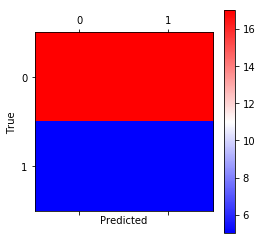

In [63]:
gnb_conf_mat = confusion_matrix(y_test, y_pred_gnb).astype('float64') 
plt.matshow(gnb_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.6. Linear Support Vector Classification

In [64]:
from sklearn.svm import LinearSVC

In [65]:
svc_clf = LinearSVC(random_state = 42, class_weight='balanced')
ts = time.time()
svc_clf.fit(X_train, y_train)
svc_train_time = time.time() - ts

In [66]:
ts = time.time()
y_pred_svc = svc_clf.predict(X_test)
svc_predict_time = time.time() - ts

In [67]:
f1_svc = f1_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
print('Linear Support Vector Classification metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_svc, precision_svc, recall_svc))

Linear Support Vector Classification metrics:
 f1: 0.41666666666666663
 precision: 0.35714285714285715
 recall: 0.5


Text(0,0.5,'True')

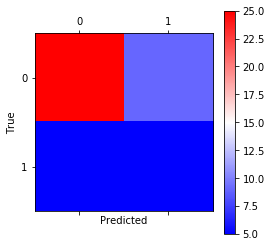

In [68]:
svc_conf_mat = confusion_matrix(y_test, y_pred_svc).astype('float64') 
plt.matshow(svc_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.7. Logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
lr_clf = LogisticRegression(random_state = 42, class_weight='balanced', solver = 'saga')
ts = time.time()
lr_clf.fit(X_train, y_train)
lr_train_time = time.time() - ts

In [71]:
ts = time.time()
y_pred_lr = lr_clf.predict(X_test)
lr_predict_time = time.time() - ts

In [72]:
f1_lr = f1_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
print('Logistic Regression metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_lr, precision_lr, recall_lr))

Logistic Regression metrics:
 f1: 0.4615384615384615
 precision: 0.375
 recall: 0.6


Text(0,0.5,'True')

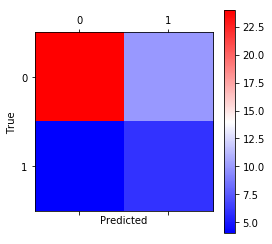

In [73]:
lr_conf_mat = confusion_matrix(y_test, y_pred_lr).astype('float64') 
plt.matshow(lr_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

In [74]:
y_pred_lr_val = lr_clf.predict(X_val)
y_pred_gnb_val = gnb_clf.predict(X_val)
y_pred_svc_val = svc_clf.predict(X_val)
y_pred_mlp_val = mlp_clf.predict(X_val)

#### 1.8. Selecting the best supervised learning model
We will use validation data to evaluate model predictions once again.

In [75]:
f1_lr_val = f1_score(y_val, y_pred_lr_val)
precision_lr_val = precision_score(y_val, y_pred_lr_val)
recall_lr_val = recall_score(y_val, y_pred_lr_val)
print('Logistic Regression validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_lr_val, precision_lr_val, recall_lr_val))

Logistic Regression validation metrics:
 f1: 0.48
 precision: 0.4
 recall: 0.6


In [76]:
f1_svc_val = f1_score(y_val, y_pred_svc_val)
precision_svc_val = precision_score(y_val, y_pred_svc_val)
recall_svc_val = recall_score(y_val, y_pred_svc_val)
print('Linear Support Vector validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_svc_val, precision_svc_val, recall_svc_val))

Linear Support Vector validation metrics:
 f1: 0.48
 precision: 0.4
 recall: 0.6


In [77]:
f1_mlp_val = f1_score(y_val, y_pred_mlp_val)
precision_mlp_val = precision_score(y_val, y_pred_mlp_val)
recall_mlp_val = recall_score(y_val, y_pred_mlp_val)
print('Multi Layer Perceptron validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_mlp_val, precision_mlp_val, recall_mlp_val))

Multi Layer Perceptron validation metrics:
 f1: 0.37037037037037035
 precision: 0.22727272727272727
 recall: 1.0


In [78]:
f1_gnb_val = f1_score(y_val, y_pred_gnb_val)
precision_gnb_val = precision_score(y_val, y_pred_gnb_val)
recall_gnb_val = recall_score(y_val, y_pred_gnb_val)
print('Gaussian Naive Bayes validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_gnb_val, precision_gnb_val, recall_gnb_val))

Gaussian Naive Bayes validation metrics:
 f1: 0.3333333333333333
 precision: 0.2857142857142857
 recall: 0.4


##### Conclusion
Logistic regressions still remains our best model. The F1 score of 0.63 is not exactly high, but we must take in consideration, that we trained the model on a very small part of our dataset. The difference in score between test and validation data shows that the randomization of the subsets can have great impact on the performance metrics in such setup.

### 2. Unsupervised learning.
Unsupervised learning methods do not require labels. Their goal is to discover intrinsic relationships in the data. Such methods can involve dimensionality reduction (Principal Components Analysis) or clustering (K-Means).

#### 2.1. Dimensionality reduction with PCA

The first 10 components explain 91.34% of variance.


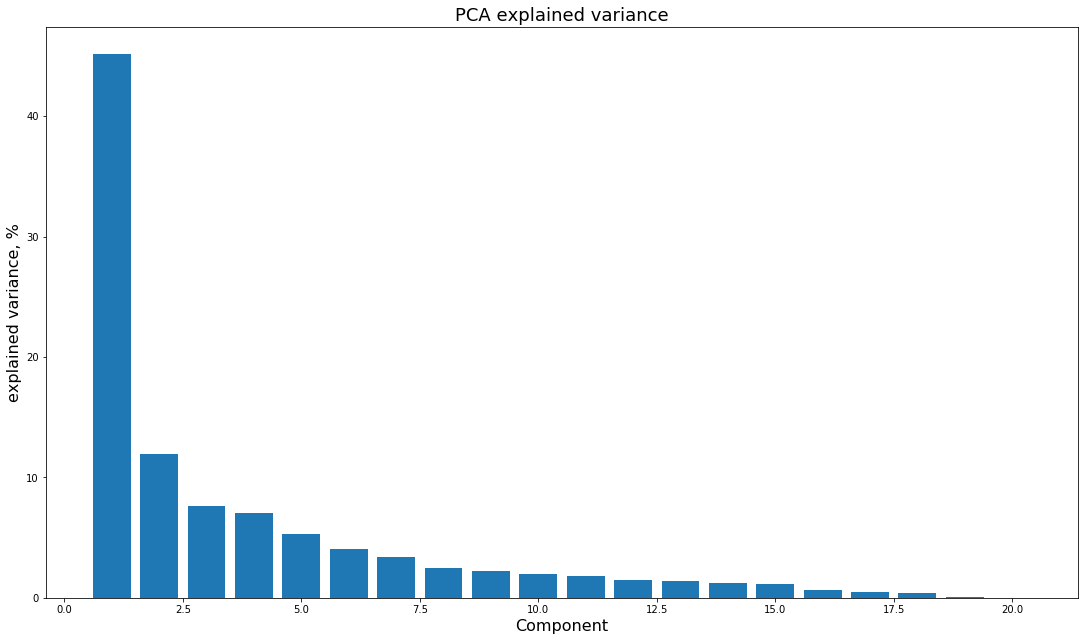

In [79]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42)
X = df_div.drop(columns = ['userID', 'churn'])
pca.fit(X)
plt.bar(range(1,21), 100*pca.explained_variance_ratio_)
plt.title('PCA explained variance', fontsize = 18)
plt.ylabel('explained variance, %', fontsize = 16)
plt.xlabel('Component', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
print('The first 10 components explain {:.2f}% of variance.'.format(100*pca.explained_variance_ratio_[:10].sum()))

In [137]:
pca = PCA(n_components = 10, random_state = 42)
X_pca = pca.fit_transform(X)

#### 2.2. Clustering with K-Means
We will apply K-Means to the transformed data to find the clusters of the users. In the next step we will see if churn can be localized to some of the clusters.

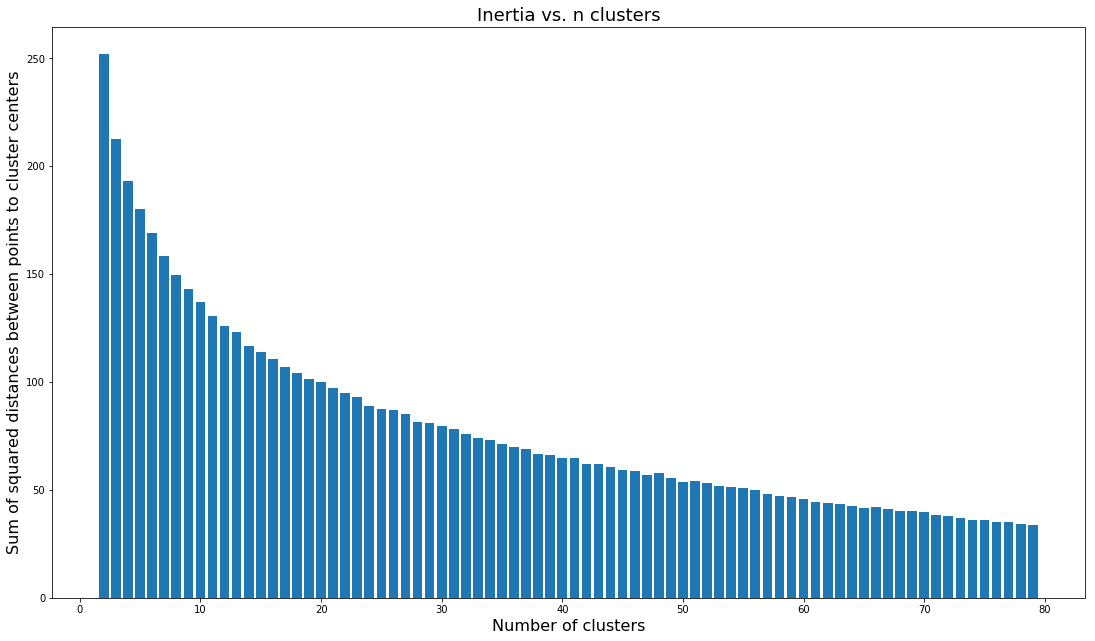

In [138]:
from sklearn.cluster import KMeans

inertia = []

for n_c in range(2,80):
    kmeans = KMeans(n_clusters = n_c, random_state = 42)
    kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)

plt.bar(range(2,80), inertia)
plt.title('Inertia vs. n clusters', fontsize = 18)
plt.ylabel('Sum of squared distances between points to cluster centers', fontsize = 16)
plt.xlabel('Number of clusters', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Using the elbow method we take 15 clusters.

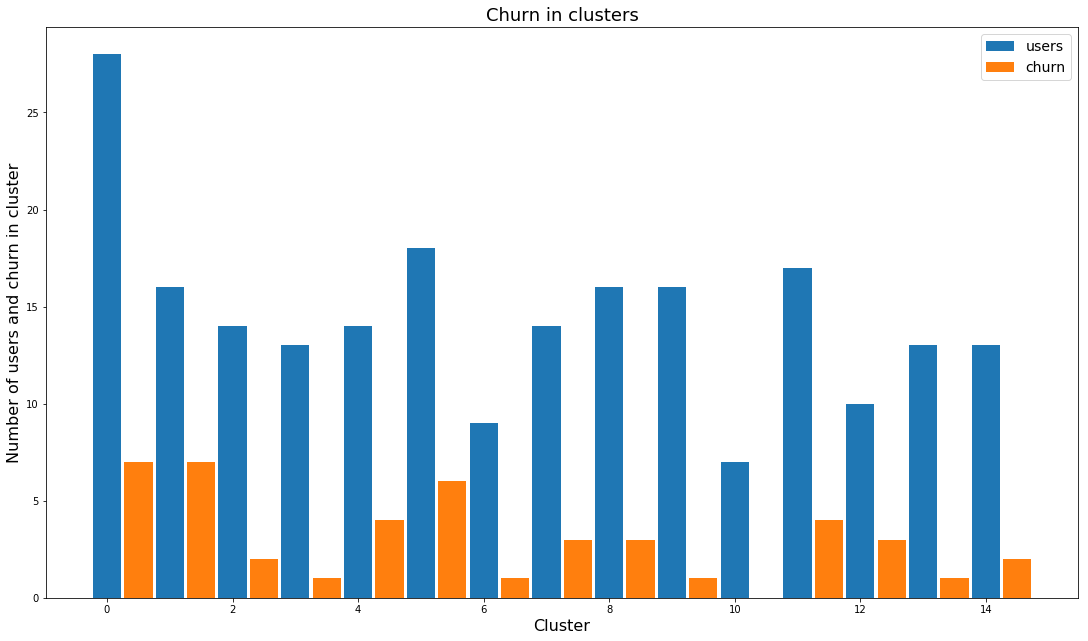

In [187]:
n_c = 15
kmeans = KMeans(n_clusters = n_c, random_state = 42)
labels = kmeans.fit_predict(X_pca).tolist()
df_kmeans = pd.DataFrame.from_dict({'userID':df_div['userID'].tolist(), 'churn':df_div['churn'].tolist(), 'cluster':labels})
plt.bar(np.arange(0,n_c), df_kmeans.groupby('cluster')['churn'].count(), width = 0.45, label = 'users')
plt.bar(np.arange(0,n_c) + 0.5, df_kmeans.groupby('cluster')['churn'].sum().tolist(), width = 0.45, label = 'churn')
plt.title('Churn in clusters', fontsize = 18)
plt.ylabel('Number of users and churn in cluster', fontsize = 16)
plt.xlabel('Cluster', fontsize = 16)
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [131]:
df_cluster_churn = pd.DataFrame.from_dict({'user count':df_kmeans.groupby('cluster')['churn'].count().tolist(),
                                           'churn count':df_kmeans.groupby('cluster')['churn'].sum()})

In [84]:
df_cluster_churn

,user count,churn count
cluster,,
0,28,7
1,16,7
2,14,2
3,13,1
4,14,4
5,18,6
6,9,1
7,14,3
8,16,3


##### Conclusion
Unfortunately unsupervised learning didn't yield the results we would like to get. Although some clusters have a high percentage of churn we can't find the optimal number of clusters from the small dataset.

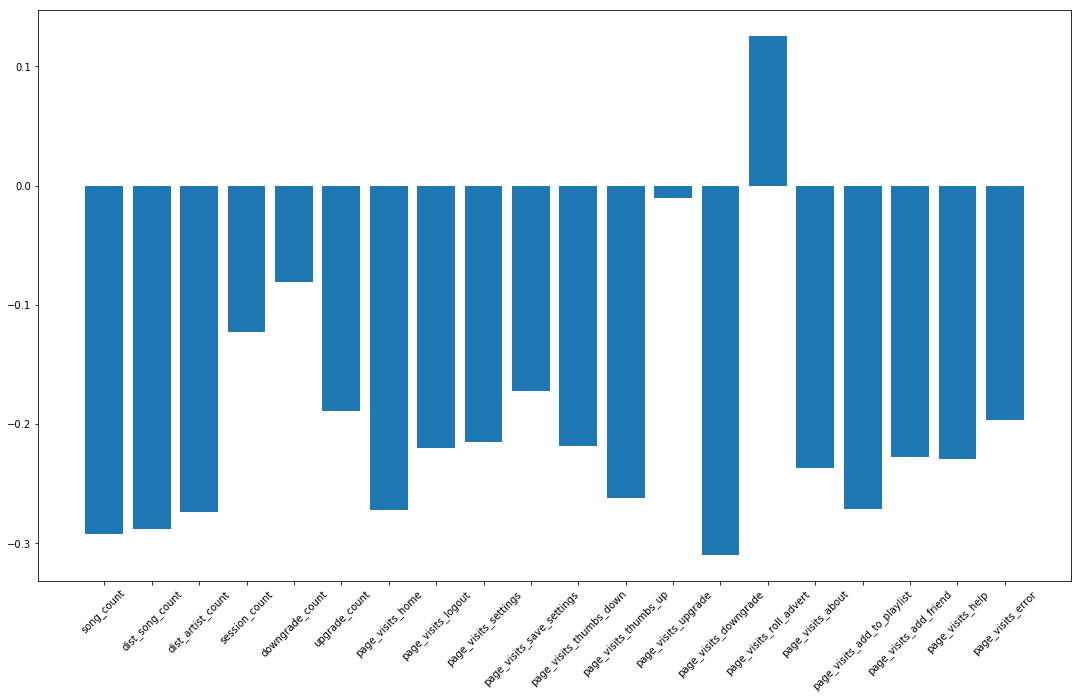

In [114]:
pca = PCA(n_components = 10, random_state = 42)
X_pca = pca.fit_transform(X)

plt.bar(np.arange(0,20),pca.components_[0])
plt.xticks(np.arange(0,20), X.columns, rotation = 45)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

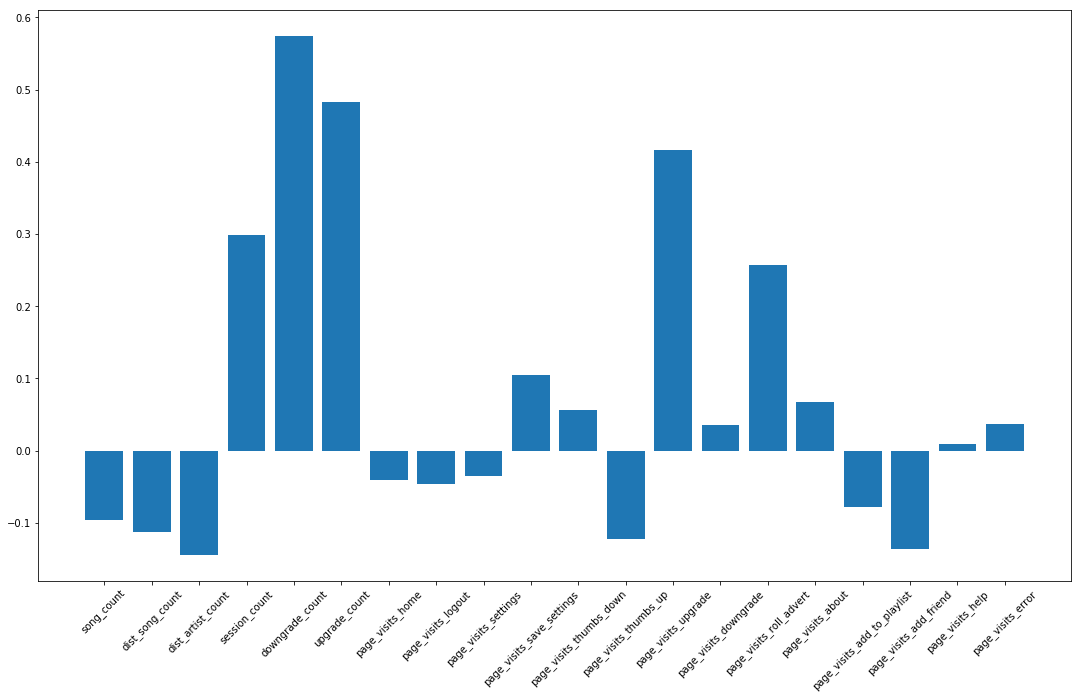

In [115]:
plt.bar(np.arange(0,20),pca.components_[1])
plt.xticks(np.arange(0,20), X.columns, rotation = 45)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

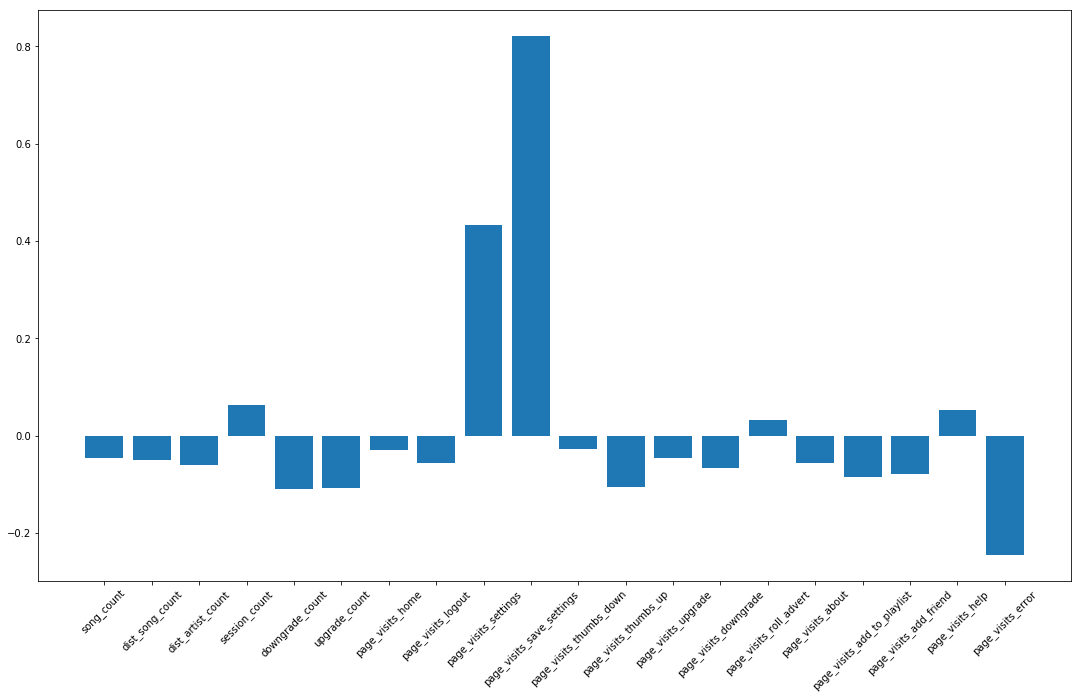

In [116]:
plt.bar(np.arange(0,20),pca.components_[3])
plt.xticks(np.arange(0,20), X.columns, rotation = 45)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

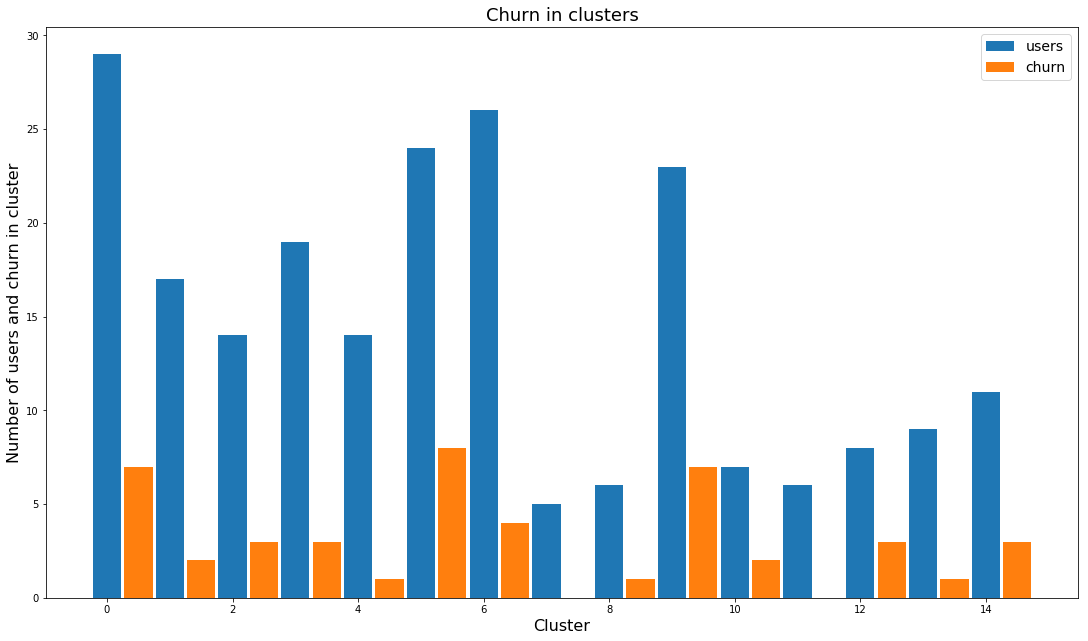

In [194]:
n_c = 15
kmeans = KMeans(n_clusters = n_c)
labels = kmeans.fit_predict(X_pca[:,2:4]).tolist()
df_kmeans = pd.DataFrame.from_dict({'userID':df_div['userID'].tolist(), 'churn':df_div['churn'].tolist(), 'cluster':labels})
plt.bar(np.arange(0,n_c), df_kmeans.groupby('cluster')['churn'].count(), width = 0.45, label = 'users')
plt.bar(np.arange(0,n_c) + 0.5, df_kmeans.groupby('cluster')['churn'].sum().tolist(), width = 0.45, label = 'churn')
plt.title('Churn in clusters', fontsize = 18)
plt.ylabel('Number of users and churn in cluster', fontsize = 16)
plt.xlabel('Cluster', fontsize = 16)
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [224]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Sparkify.ipynb'])

0